In [140]:
from matplotlib.ticker import FuncFormatter
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu
from pandas.plotting import table
import matplotlib.pyplot as plt
import dataframe_image as dfi
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import numpy as np
import scipy as sp
import scienceplots

In [141]:
plt.style.use('science')

# Get the hex codes for the colors so we can assign them to categories
pal = sns.color_palette('Paired')
print(pal.as_hex())

# Set the color palette. Our categories are "Single Domain", "Two-Domain", and "Autoinhibitory"
colors = {'Single Domain': pal[0], 'Two-Domain': pal[1], 'Autoinhibitory': pal[3], 'Autoinhibitory (Active)': pal[2], 'Autoinhibitory (Autoinhibited)': pal[3], 
          'Full': pal[3], 'Clusters': pal[7], 'Two-State AI': pal[4], 'Autoinhibitory (Closed)': pal[5], 'Autoinhibitory (Open)': pal[4]}
pal.as_hex()

['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']


['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

In [142]:
# Load the data
cl = pd.read_csv('./project_pipeline/data/classified_files.tsv', sep='\t')
rmsd = pd.read_csv('./project_pipeline/data/rmsds.tsv', sep='\t').astype('object')
md = pd.read_csv('./project_pipeline/data/md_rmsds.tsv', sep='\t').astype('object')

cl.head()

,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,2_comp,state,conformation,organism,date,notes
0,P04637,8f2h,364-393,102-292,30.431,100.0,100.000000,3.065,70.729,Autoinhibited,Closed,"""Homo sapiens""",['2022-11-08'],NaN
1,P04637,8f2i,364-393,102-292,30.431,100.0,100.000000,3.065,70.729,Autoinhibited,Closed,"""Homo sapiens""",['2022-11-08'],NaN
2,P00523,2ptk,"148-245,246-266","81-142,521-533",1.737,100.0,89.333333,1.921,3.093,Autoinhibited,Closed,Gallus gallus,['1997-06-17'],NaN
3,P28482,1pme,173-196,"25-172,197-313",2.422,100.0,96.603774,1.220,6.639,Autoinhibited,Closed,Homo sapiens,['1998-06-08'],NaN
4,P28482,1tvo,173-196,"25-172,197-313",2.497,100.0,100.000000,1.523,6.633,Autoinhibited,Closed,Homo sapiens,['2004-06-30'],NaN


In [143]:
# We need to group by protein (uniprot) and find the minimum value of the 2_comp column

exem = cl.sort_values('2_comp').groupby('uniprot', as_index=False).first()

print(exem['conformation'].value_counts())


Closed    116
Open       12
Name: conformation, dtype: int64


In [144]:
# We want only closed structures
exem_closed = exem[exem['conformation'] == 'Closed']
print(len(exem_closed))
closed_uniprots = exem_closed['uniprot'].tolist()
closed_pdb = exem_closed['pdb'].tolist()

md_exem = md.sort_values('2_comp').groupby('uniprot', as_index=False).first()
md_pdb = md_exem['pdb'].tolist()
print(len(md_exem))
print(md_pdb)

116
40
['5ups', '6m01', '5tw8', '5wm5', '7vxq', '5kei', '5iz1', '4ir8', '3myr', '6ur9', '4ueq', '3ayz', '4wv3', '4d4i', '5n4b', '5n9x', '7a9j', '3dy5', '1ohe', '4mgf', '2j3x', '1ig8', '5n0c', '1a62', '1qme', '1e8n', '1pyy', '1ru3', '5zwk', '6e97', '3pbs', '4rmn', '6ruc', '3txm', '2p3y', '3cw9', '4cdp', '3a9u', '6s62', '1e3d']


In [145]:
# Reformat the data for plotting

# Add 1_aligned to classified files
rmsdSub = rmsd[['uniprot', 'pdb', '1_aligned']]
exem = exem_closed.merge(rmsdSub, on=['uniprot', 'pdb'], how='left')

# Select columns of interest
clSub = exem[['uniprot', 'pdb', 'complex_rmsd', '1_aligned', '2_aligned', '2_comp']]

# Rename columns
clSub.columns = ['Uniprot', 'PDB', 'Full Sequence', 'IM', 'FD', 'IM on FD']

clSub[['Full Sequence', 'IM', 'FD', 'IM on FD']] = clSub[['Full Sequence', 'IM', 'FD', 'IM on FD']].astype(float)

# Melt the data
plot = pd.melt(clSub, id_vars=['Uniprot', 'PDB'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
plot['RMSD'] = plot['RMSD'].astype(float)

# Remove outliers above 100 RMSD
plot = plot[plot['RMSD'] < 100]

/tmp/ipykernel_1095503/3211990202.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clSub[['Full Sequence', 'IM', 'FD', 'IM on FD']] = clSub[['Full Sequence', 'IM', 'FD', 'IM on FD']].astype(float)


In [146]:
# Add in multi-domain data

md = pd.read_csv('./project_pipeline/data/md_rmsds.tsv', sep='\t').astype('object')

# Subset the data
mdSub = md[['uniprot', 'pdb', 'complex_rmsd', '1_aligned', '2_aligned', '2_comp']]

# Rename columns
mdSub.columns = ['Uniprot', 'PDB', 'Full Sequence', 'D1', 'D2', 'D1 on D2']

# Melt the data
mdPlot = pd.melt(mdSub, id_vars=['Uniprot', 'PDB'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
mdPlot['RMSD'] = mdPlot['RMSD'].astype(float)

In [147]:
# Add types to the dataframes
clSub['Type'] = 'Autoinhibitory (Closed)'
mdSub['Type'] = 'Two-Domain'

# Rename the columns to match
clSub.columns = ['UniProt', 'PDB', 'Full Sequence', 'IM/D1', 'FD/D2', 'IM on FD/D1 on D2', 'Type']
mdSub.columns = ['UniProt', 'PDB', 'Full Sequence', 'IM/D1', 'FD/D2', 'IM on FD/D1 on D2', 'Type']

# Concatenate the dataframes
allPlot = pd.concat([clSub, mdSub])

# Melt the data
allPlot = pd.melt(allPlot, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
allPlot['RMSD'] = allPlot['RMSD'].astype(float)

# Remove outliers
allPlot = allPlot[allPlot['RMSD'] < 100]
mdSub.head()

/tmp/ipykernel_1095503/2205942897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clSub['Type'] = 'Autoinhibitory (Closed)'
/tmp/ipykernel_1095503/2205942897.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdSub['Type'] = 'Two-Domain'


,UniProt,PDB,Full Sequence,IM/D1,FD/D2,IM on FD/D1 on D2,Type
0,D9N168,3ht3,1.115,0.883,1.153,0.979,Two-Domain
1,D9N168,4o0i,1.166,0.826,1.253,0.999,Two-Domain
2,D9N168,6ueu,1.787,0.72,2.667,1.017,Two-Domain
3,D9N168,6ur2,1.208,0.836,1.317,0.998,Two-Domain
4,D9N168,6ur4,1.208,0.842,1.275,1.073,Two-Domain


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM/D1_Autoinhibitory (Closed) vs. IM/D1_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:2.015e-11 U_stat=1.534e+04


/tmp/ipykernel_1095503/1134918773.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


Full Sequence_Autoinhibitory (Closed) vs. Full Sequence_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:2.083e-13 U_stat=1.580e+04
FD/D2_Autoinhibitory (Closed) vs. FD/D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.645e-14 U_stat=1.604e+04
IM on FD/D1 on D2_Autoinhibitory (Closed) vs. IM on FD/D1 on D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.712e-07 U_stat=1.416e+04


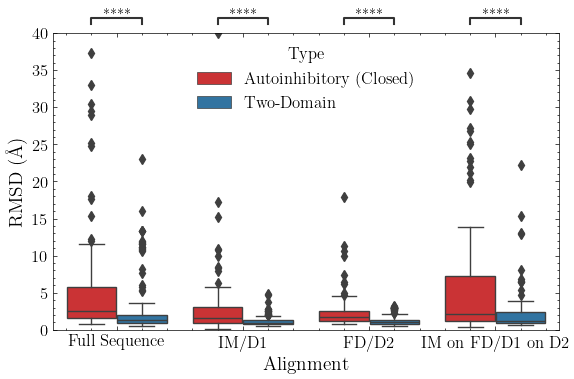

In [148]:
# Now we plot the data
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=allPlot, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type')
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', fontsize=12, title_fontsize=12)

# Add the annotations, comparing between structural alignment categories
pairs = [[('Full Sequence', 'Autoinhibitory (Closed)'), ('Full Sequence', 'Two-Domain')],
         [('IM/D1', 'Autoinhibitory (Closed)'), ('IM/D1', 'Two-Domain')],
         [('FD/D2', 'Autoinhibitory (Closed)'), ('FD/D2', 'Two-Domain')],
         [('IM on FD/D1 on D2', 'Autoinhibitory (Closed)'), ('IM on FD/D1 on D2', 'Two-Domain')]]
subcat_order = ['Full Sequence', 'IM/D1', 'FD/D2', 'IM on FD/D1 on D2']
annotator = Annotator(ax, pairs, data=allPlot, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# Save the plot
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/closed_rmsd_distributions.png', dpi=500, bbox_inches='tight')

## Now we do the PAE

In [149]:
df_auto = pd.read_csv('./project_pipeline/data/disorder.tsv', sep='\t').astype('object')
df_single = pd.read_csv('./project_pipeline/data/single_domain_pae.tsv', sep='\t').astype('object')
df_multi = pd.read_csv('./project_pipeline/data/multi_domain_pae.tsv', sep='\t').astype('object')

In [150]:
df_pae = df_auto[['uniprot', 'mean_pae_1_1', 'mean_pae_1_2', 'mean_pae_2_2']]

pae_closed = df_pae[df_pae['uniprot'].isin(closed_uniprots)].drop_duplicates(subset='uniprot')
print(len(pae_closed))

112


In [151]:


# Remove all rows with multiple regions. Comment this out if you want to see the difference.
for i in range(len(df_single)):
    region = df_single.loc[i, 'region']
    count = region.count('-')
    if count > 1:
        df_single = df_single.drop(i)


# Reformat the singles dataframe
df_single = df_single[['uniprot', 'mean_pae']].dropna()
df_single = df_single.astype({'mean_pae': 'float'})
df_single = df_single.rename(columns={'mean_pae': 'Single Domain'})
df_single_melt = df_single.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae')

# Reformat all pae dataframe
df_pae = pae_closed.rename(columns={'mean_pae_1_1': 'IM', 'mean_pae_1_2': 'IM on FD', 'mean_pae_2_2': 'FD'})
df_pae_melt = df_pae.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae').drop_duplicates()

# Reformat the multi dataframe
df_multi = df_multi[['uniprot', 'mean_pae_1_1', 'mean_pae_1_2', 'mean_pae_2_2']].dropna().reset_index(drop=True)
df_multi = df_multi.rename(columns={'mean_pae_1_1': 'D1', 'mean_pae_1_2': 'D1 on D2', 'mean_pae_2_2': 'D2'})
df_multi_melt = df_multi.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae').drop_duplicates()

# Add type column
df_pae_melt['type'] = 'Autoinhibitory (Closed)'
df_single_melt['type'] = 'Single Domain'
df_multi_melt['type'] = 'Two-Domain'

# Merge all dataframes
df_all = pd.concat([df_single_melt, df_pae_melt, df_multi_melt], ignore_index=True).drop_duplicates()
df_all['mean_pae'] = df_all['mean_pae'].astype('float')

/tmp/ipykernel_1095503/3781635464.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

D2_Two-Domain vs. FD_Autoinhibitory (Closed): Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:4.821e-13 U_stat=8.270e+02
D1_Two-Domain vs. IM_Autoinhibitory (Closed): Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.509e-03 U_stat=1.918e+03
D1 on D2_Two-Domain vs. IM on FD_Autoinhibitory (Closed): Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.543e-02 U_stat=2.148e+03
Single Domain_Single Domain vs. D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.522e-05 U_stat=9.643e+03
Single Domain_Single Domain vs. FD_Autoinhibitory (Closed): Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:4.715e-05 U_stat=1.022e+04
Single Domain_Single Domain vs. D1_Two-Domain: Mann-Whitney-W

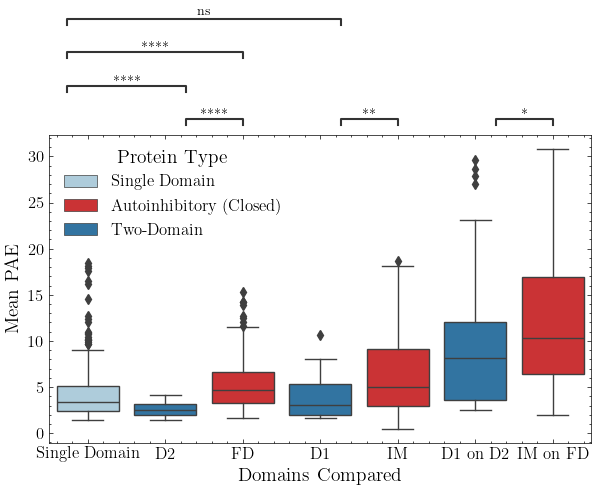

In [152]:
region_order = ['Single Domain', 'D2', 'FD', 'D1', 'IM', 'D1 on D2', 'IM on FD']

f, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(data=df_all, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors, dodge=False)
ax.set_xlabel('Domains Compared', fontsize=14)
ax.set_ylabel('Mean PAE', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Protein Type', title_fontsize='14', fontsize='12') 

# Annotate statistical significance

pairs = [[('Single Domain', 'Single Domain'), ('FD', 'Autoinhibitory (Closed)')],
         [('Single Domain', 'Single Domain'), ('D2', 'Two-Domain')],
         [('Single Domain', 'Single Domain'), ('D1', 'Two-Domain')],
         [('FD', 'Autoinhibitory (Closed)'), ('D2', 'Two-Domain')],
         [('IM', 'Autoinhibitory (Closed)'), ('D1', 'Two-Domain')],
         [('IM on FD', 'Autoinhibitory (Closed)'), ('D1 on D2', 'Two-Domain')]]
annotator = Annotator(ax, pairs, data=df_all, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction="bonferroni")
_, corrected_results = annotator.apply_and_annotate()

# Save the figure
plt.savefig('./project_pipeline/data/figures/closed_sd_md_proteins_pae_annotated.png')

In [153]:
# Functions to rename columns

def rename_auto_columns(df):
    df = df.rename(columns={'complex_mean_plddt': 'Full Sequence', 'r1_mean_plddt': 'IM/D1', 'r2_mean_plddt': 'FD/D2'})

    return df

def rename_multi_columns(df):
    df = df.rename(columns={'complex_mean_plddt': 'Full Sequence', 'r1_mean_plddt': 'IM/D1', 'r2_mean_plddt': 'FD/D2'})

    return df

# Quick functions to melt dataframes
def pivot_af_df(df):

    df = df.melt(id_vars=['uniprot', 'region_1', 'region_2', 'af_filename'], var_name='Section', value_name='Mean pLDDT')
    df['Mean pLDDT'] = df['Mean pLDDT'].astype(float)

    return df

def pivot_cf_df(df):

    df = df.melt(id_vars=['uniprot', 'cluster', 'region_1', 'region_2', 'cf_filename'], var_name='Section', value_name='Mean pLDDT')
    df['Mean pLDDT'] = df['Mean pLDDT'].astype(float)

    return df

# Add signifier column
def add_auto_type(df):
    df['type'] = 'Autoinhibitory (Closed)'

    return df

def add_multi_type(df):
    df['type'] = 'Two-Domain'

    return df

In [154]:
afAuto = pd.read_csv('./project_pipeline/data/af_autoinhibited_pLDDT.tsv', sep='\t').astype('object')
afMulti = pd.read_csv('./project_pipeline/data/af_multi_domain_pLDDT.tsv', sep='\t').astype('object')

afAuto = afAuto.drop(columns=['pdb', 'complex_rmsd', 'percent_region_1', 'percent_region_2', 
                    '2_aligned', '2_comp', 'conformation', 'state', 'organism', 
                    'date', 'notes'])

afAuto = afAuto[afAuto['uniprot'].isin(closed_uniprots)].drop_duplicates(subset='uniprot').reset_index(drop=True)
print(len(afAuto))

afMulti = afMulti.drop(columns=['mean_pae_1_1', 'mean_pae_1_2', 'mean_pae_2_2'])

112


In [155]:
# Rename columns
af_auto = rename_auto_columns(afAuto)
af_multi = rename_multi_columns(afMulti)

# Pivot dataframes
afAuto_p = pivot_af_df(af_auto)
afMulti_p = pivot_af_df(af_multi)

# Add type column
afAuto_p = add_auto_type(afAuto_p)
afMulti_p = add_multi_type(afMulti_p)

# Concatenate dataframes
af = pd.concat([afAuto_p, afMulti_p])

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM/D1_Autoinhibitory (Closed) vs. IM/D1_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.682e-10 U_stat=1.137e+03


/tmp/ipykernel_1095503/1278764341.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


Full Sequence_Autoinhibitory (Closed) vs. Full Sequence_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:4.574e-16 U_stat=6.400e+02
FD/D2_Autoinhibitory (Closed) vs. FD/D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:2.053e-07 U_stat=1.479e+03


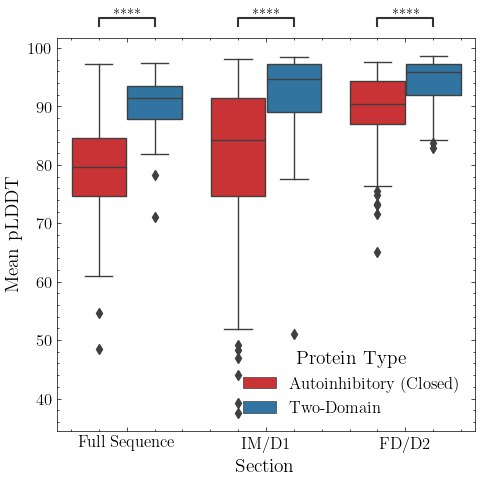

In [156]:


fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(data=af, x='Section', y='Mean pLDDT', ax = ax, hue='type', palette=colors)
ax.set_ylabel('Mean pLDDT', fontsize=14)
ax.set_xlabel('Section', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Protein Type', title_fontsize='14', fontsize='12')


# Annotate statistical significance
pairs = [[('Full Sequence', 'Autoinhibitory (Closed)'), ('Full Sequence', 'Two-Domain')],
         [('IM/D1', 'Autoinhibitory (Closed)'), ('IM/D1', 'Two-Domain')],
         [('FD/D2', 'Autoinhibitory (Closed)'), ('FD/D2', 'Two-Domain')]]
subcat_order = ['Full Sequence', 'IM/D1', 'FD/D2']
annotator = Annotator(ax, pairs, data=af, x='Section', y='Mean pLDDT', order=subcat_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# Save the figure
plt.style.use('science')
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/af_closed_multi_plddt.png', dpi=300, bbox_inches='tight')

## Now for DockQ

In [157]:
ai1 = pd.read_csv('./project_pipeline/data/ai_dockq_results.csv').astype('object')
md_dockq = pd.read_csv('./project_pipeline/data/md_dockq_results.csv').astype('object')

ai = ai1[ai1['pdb'].isin(closed_pdb)].reset_index(drop=True)
ai = ai[ai['uniprot'].isin(closed_uniprots)].reset_index(drop=True)

md_dockq = md_dockq[md_dockq['pdb'].isin(md_pdb)].reset_index(drop=True)
print(len(ai))

116


In [158]:
md_dockq['type'] = 'Two-Domain'
md_dockq.head()


ai['type'] = 'Autoinhibitory (Closed)'

ai_sub = ai[['uniprot', 'pdb', 'fnat', 'fnat_correct', 'fnat_total', 'fnonnat',
       'fnonnat_nnative', 'fnonnat_model', 'irms', 'lrms', 'dockq', 'capri',
       'type']]

plot = pd.concat([ai_sub, md_dockq], ignore_index=True)
plot.head()

,uniprot,pdb,fnat,fnat_correct,fnat_total,fnonnat,fnonnat_nnative,fnonnat_model,irms,lrms,dockq,capri,type
0,Q96FI4,4nrv,0.944,17,18,0.056,1,18,0.523,0.436,0.944,High,Autoinhibitory (Closed)
1,P14921,1gvj,0.772,44,57,0.137,7,51,9.909,23.751,0.303,Acceptable,Autoinhibitory (Closed)
2,Q06124,6mdc,0.919,79,86,0.092,8,87,0.327,0.413,0.957,High,Autoinhibitory (Closed)
3,Q5Y4Y6,5b5r,0.705,55,78,0.433,42,97,4.032,4.75,0.53,Medium,Autoinhibitory (Closed)
4,P18654,4mao,0.943,50,53,0.153,9,59,0.863,1.76,0.885,High,Autoinhibitory (Closed)


/tmp/ipykernel_1095503/1941098761.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


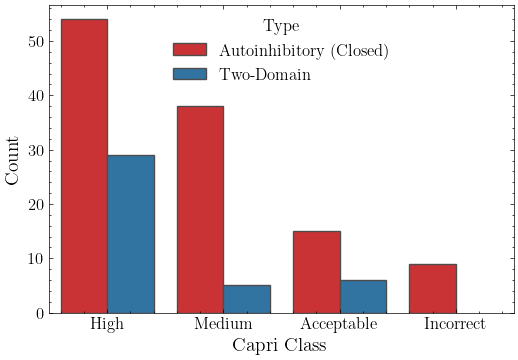

In [159]:
# Make the capri class categorical
plot['capri'] = pd.Categorical(plot['capri'], ['High', 'Medium', 'Acceptable', 'Incorrect'])

# Make histograms of both
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Autoinhibitory DockQ
sns.countplot(data=plot, x='capri', hue='type', ax=ax, palette=colors, edgecolor='.3')
ax.set_xlabel('Capri Class', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', fontsize=12, title_fontsize=12)

plt.savefig('./project_pipeline/data/figures/dockq_histograms.png', dpi=300)